# auto layout 排版

## 线性规划 ,课后可了解下pulp

In [14]:
import pulp

#目标函数的系数
z = [2, 3, 1]

#约束
a = [[1, 4, 2], [3, 2, 0]]
b = [8, 6]

#确定最大化最小化问题，最大化只要把Min改成Max即可
m = pulp.LpProblem(sense=pulp.LpMinimize)
print(m)

#定义三个变量放到列表中
x = [pulp.LpVariable('x_'+str(i), lowBound=0) for i in [1,2,3]]
print(x)


'''定义目标函数，lpDot可以将两个列表的对应位相乘再加和
z = [2, 3, 1]
x = [x_1, x_2, x_3]

pulp.lpDot(z, x)

相当于

z[0]*x[0]+z[1]*x[0]+z[2]*x[2]

'''
m += pulp.lpDot(z, x)
print(m)

#设置约束条件
for i in range(len(a)):
    m += (pulp.lpDot(a[i], x) >= b[i])
print(m) 

#求解
m.solve()

#输出结果
print(f'优化结果：{pulp.value(m.objective)}')
print(f'参数取值：{[pulp.value(var) for var in x]}')


NoName:
MINIMIZE
None
VARIABLES

[x_1, x_2, x_3]
NoName:
MINIMIZE
2*x_1 + 3*x_2 + 1*x_3 + 0
VARIABLES
x_1 Continuous
x_2 Continuous
x_3 Continuous

NoName:
MINIMIZE
2*x_1 + 3*x_2 + 1*x_3 + 0
SUBJECT TO
_C1: x_1 + 4 x_2 + 2 x_3 >= 8

_C2: 3 x_1 + 2 x_2 >= 6

VARIABLES
x_1 Continuous
x_2 Continuous
x_3 Continuous

优化结果：7.0
参数取值：[2.0, 0.0, 3.0]


In [23]:
'''Min z=y2-y1-height
height<=H*0.3
y2<=H*0.5
y2>=y1
y1>=H*0.1
height>=y1
y2-y1-height>=H*0.1
'''


'Min z=y2-y1-height\nheight<480*0.3\ny2<480*0.5\ny2>96\ny1>48\nheight>96\n'

In [31]:
prob=pulp.LpProblem(sense=pulp.LpMinimize)
H=480
y2=pulp.LpVariable('y2', lowBound =int(H*0.1))
y1=pulp.LpVariable('y1', lowBound =int(H*0.1))
height=pulp.LpVariable('height', lowBound =int(H*0.1))
 
prob+=y2-y1-height

prob+=height<=int(H*0.3)
prob+=y2<=int(H*0.5)
prob+=y2-y1-height>=int(H*0.1)

prob.solve()
print(f'优化结果：{pulp.value(prob.objective)}')
print(f'参数取值：{[pulp.value(var) for var in [y1,y2,height]]}')


优化结果：48.0
参数取值：[48.0, 144.0, 48.0]


## cassowary
#### 所谓编程范式（programming paradigm），指的是计算机编程的基本风格或典范模式。
#### 约束编程，声明式编程

In [ ]:
# pip install cassowary
#https://cassowary.readthedocs.io/en/latest/

In [9]:
# demo
from cassowary import SimplexSolver,Variable

# 初始化
solver = SimplexSolver()

# Create a variable with a default value.
x1 = Variable('x1')
x2 = Variable('x2')
x3 = Variable('x3')

# Define the constraint
solver.add_constraint(x1 + 3 * x2 <= 4 * x3 + 2)
solver.add_constraint(x1 >=3)
solver.add_constraint(x3 >=3)

Required:{1.0}(-3.0 + x3[3.0])

In [10]:
x2.value,x1.value,x3.value

(3.6666666666666665, 3.0, 3.0)

In [11]:
from cassowary import SimplexSolver, Variable,STRONG, WEAK

# 中间点必须位于左右点之间；
# 左点必须至少在右点的左边10；
# 所有点必须在0-100范围内。

solver = SimplexSolver()

left = Variable('left')
middle = Variable('middle')
right = Variable('right')

solver.add_constraint(middle == (left + right) / 2)
solver.add_constraint(right == left + 10)
solver.add_constraint(right <= 100)
solver.add_constraint(left >= 10,strength=STRONG)


Strong:{1.0}(-10.0 + left[90.0])

In [12]:
#求解器提供了一种可能的解决方案
left.value,middle.value,right.value

(90.0, 95.0, 100.0)

In [13]:
#固定值
middle.value = 45.0
solver.add_stay(middle)
left.value,middle.value,right.value

(40.0, 45.0, 50.0)

In [ ]:
# Cassowary允许设置约束都具有强度
# REQUIRED STRONG MEDIUM WEAK

## 布局的例子

In [15]:
from cassowary import SimplexSolver, Variable,STRONG,WEAK

solver = SimplexSolver()
class Button(object):
    def __init__(self, identifier):
        self.left = Variable('left' + identifier, 0)
        self.width = Variable('width' + identifier, 0)

    def __repr__(self):
        return u'(x=%s, width=%s)' % (self.left.value, self.width.value)

In [16]:
b1 = Button('b1')
b2 = Button('b2')
left_limit = Variable('left', 0)
right_limit = Variable('width', 0)

left_limit.value = 0
solver.add_stay(left_limit)
solver.add_stay(right_limit, WEAK)

stay:Weak:{1.0}(-1.0*width[0.0])

In [17]:
# The two buttons are the same width
solver.add_constraint(b1.width == b2.width)

# Button1 starts 50 from the left margin.
solver.add_constraint(b1.left == left_limit + 50)

# Button2 ends 50 from the right margin
solver.add_constraint(left_limit + right_limit == b2.left + b2.width + 50)

# Button2 starts at least 100 from the end of Button1. This is the
# "elastic" constraint in the system that will absorb extra space
# in the layout.
solver.add_constraint(b2.left == b1.left + b1.width + 100)

# Button1 has a minimum width of 87
solver.add_constraint(b1.width >= 87)

# Button1's preferred width is 87
solver.add_constraint(b1.width == 87, strength=STRONG)

# Button2's minimum width is 113
solver.add_constraint(b2.width >= 113)

# Button2's preferred width is 113
solver.add_constraint(b2.width == 113, strength=STRONG)

Strong:{1.0}(113.0 + -1.0*widthb2[113.0])

In [18]:
b1,b2,right_limit.value

((x=50.0, width=113.0), (x=263.0, width=113.0), 426.0)

# 遗传算法

## OneMax问题是遗传算法的入门问题
## 如何使一段长度固定的二进制字符串所有位置上数字之和最大。

个体：个体即为问题的解，这个问题中个体可以直观的定义为一个长度为100列表（List），列表上每个元素为0或1.

种群：种群即所有个体的合集，我们可以把种群定义为所有个体组成的列表。

选择：使用锦标赛法(Tournament Selection)

杂交：使用单点杂交法(Singe-Point Crossover)

突变：使用位翻转突变法(Flip Bit Mutation)

适应度函数： 我们的目标是使字符串上所有数字之和最大，适应度函数可以直观的定义为列表中所有数字之和


/Users/shadow/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/shadow/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	max	avg  
0  	200   	9  	4.935
1  	179   	9  	5.785
2  	188   	9  	6.64 
3  	186   	10 	7.46 
4  	185   	10 	7.865
5  	176   	10 	8.375
6  	182   	10 	8.805
7  	167   	10 	9.135
8  	164   	10 	9.485
9  	185   	10 	9.74 
10 	182   	10 	9.875
11 	178   	10 	9.84 
12 	183   	10 	9.915
13 	183   	10 	9.945
14 	181   	10 	9.9  
15 	172   	10 	9.925
16 	198   	10 	9.925
17 	177   	10 	9.855
18 	189   	10 	9.925
19 	175   	10 	9.865
20 	191   	10 	9.825
21 	182   	10 	9.89 
22 	184   	10 	9.9  
23 	188   	10 	9.895
24 	191   	10 	9.85 
25 	173   	10 	9.875
26 	179   	10 	9.895
27 	183   	10 	9.86 
28 	183   	10 	9.915
29 	190   	10 	9.845
30 	170   	10 	9.91 
31 	178   	10 	9.9  
32 	181   	10 	9.915
33 	186   	10 	9.85 
34 	185   	10 	9.855
35 	180   	10 	9.88 
36 	189   	10 	9.885
37 	182   	10 	9.82 
38 	178   	10 	9.875
39 	178   	10 	9.89 
40 	182   	10 	9.865
41 	182   	10 	9.89 
42 	179   	10 	9.935
43 	178   	10 	9.905
44 	173   	10 	9.895
45 	181   	10 	9.855
46 	182   	10

424	183   	10 	9.875
425	192   	10 	9.875
426	182   	10 	9.875
427	185   	10 	9.945
428	184   	10 	9.89 
429	193   	10 	9.91 
430	182   	10 	9.845
431	175   	10 	9.915
432	184   	10 	9.86 
433	183   	10 	9.85 
434	188   	10 	9.87 
435	191   	10 	9.88 
436	194   	10 	9.92 
437	178   	10 	9.915
438	186   	10 	9.89 
439	192   	10 	9.91 
440	178   	10 	9.865
441	185   	10 	9.925
442	187   	10 	9.895
443	193   	10 	9.92 
444	184   	10 	9.89 
445	176   	10 	9.885
446	176   	10 	9.925
447	180   	10 	9.93 
448	181   	10 	9.87 
449	174   	10 	9.905
450	183   	10 	9.87 
451	189   	10 	9.93 
452	186   	10 	9.895
453	172   	10 	9.79 
454	187   	10 	9.93 
455	175   	10 	9.935
456	183   	10 	9.91 
457	172   	10 	9.875
458	163   	10 	9.9  
459	180   	10 	9.91 
460	179   	10 	9.865
461	190   	10 	9.895
462	185   	10 	9.89 
463	180   	10 	9.89 
464	182   	10 	9.88 
465	178   	10 	9.875
466	180   	10 	9.92 
467	190   	10 	9.845
468	189   	10 	9.88 
469	190   	10 	9.91 
470	186   	10 	9.925
471	176   	10

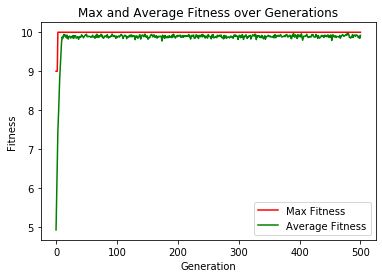

In [31]:
#导入模块
from deap import base,creator,tools,algorithms
import random
import numpy as np
import matplotlib.pyplot as plt


toolbox = base.Toolbox()

# 参数:
INDIVIDUAL_LENGTH = 10  # length of bit string to be optimized
POPULATION_SIZE =200
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 500
random.seed(39)

# 3.create individual and population

#优化目标：单变量，求最大值
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

#创建Individual类，继承list
creator.create("Individual", list, fitness=creator.FitnessMax)

# 生成个体
toolbox.register("Binary", random.randint, 0, 1)
toolbox.register("createIndividual", tools.initRepeat, creator.Individual, toolbox.Binary, INDIVIDUAL_LENGTH)

#print('生成个体',toolbox.createIndividual())


# 生成初始族群
toolbox.register("createPopulation", tools.initRepeat, list, toolbox.createIndividual)

#print()


# 4. define evaluation function
# 定义评价函数
def evalOneMax(individual):
    #[0,1,1]   , [1,1,1]  , [0,0,0]
    return sum(individual),
toolbox.register("evaluate",evalOneMax)

# 5. define operators
#配种选择,方式1,锦标赛方式
toolbox.register("select", tools.selTournament, tournsize=2)
#变异,单点交叉
toolbox.register("mate", tools.cxOnePoint)
#突变,位翻转突变
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/INDIVIDUAL_LENGTH)


# Genetic Algorithm flow:
def main():
    # create population
    population = toolbox.createPopulation(n=POPULATION_SIZE)
    #print('族群',population)
    #print()
    # initialize statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)

    '''population
           toolbox
           cxpb –配对两个体的概率。
           mutpb –个体变异的概率。
           ngen –世代数。
           stats –一个Statistics就地更新的对象，可选。
           verbose –是否记录统计信息。'''
        
    # 遗传算法   Genetic Algorithm
    population, logbook = algorithms.eaSimple(
        population, 
        toolbox, 
        cxpb=P_CROSSOVER, 
        mutpb=P_MUTATION, 
        ngen=MAX_GENERATIONS,
        stats=stats, 
        verbose=True)



    # gather statistics
    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

    # 输出最优解
    index = np.argmax([ind.fitness for ind in population])
    x = population[index] # 解码
    print('当前最优解：'+ str(x) + '\t对应的函数值为：' + str(population[index].fitness))
    
    # plot statistics:
    plt.plot(maxFitnessValues, color='red',label="Max Fitness")
    plt.plot(meanFitnessValues, color='green',label="Average Fitness")
    plt.legend()
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Max and Average Fitness over Generations')
    plt.show()

main()

## 图形

### 在方格内寻找面积最大的三角形，输出三角形的坐标定位

In [33]:
#通过三点直接求面积
def calc_area(p1, p2, p3):
    (x1, y1), (x2, y2), (x3, y3) = p1,p2,p3
    return 0.5 * abs(x2 * y3 + x1 * y2 + x3 * y1 - x3 * y2 - x2 * y1 - x1 * y3)

calc_area((10,10),(30,120),(0,0))

450.0

/Users/shadow/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/shadow/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


随机 生成  个体 : [7, 9, 13, 1, 4, 14]
gen	nevals	max  	avg   	min
0  	200   	229.5	56.405	0  
1  	193   	258  	68.8625	0  
2  	188   	280  	77.5625	0  
3  	188   	304  	85.175 	0  
4  	177   	324  	92.1   	0  
5  	185   	368  	105.61 	0  
6  	178   	336  	104.328	0  
7  	183   	327  	118.04 	0  
8  	177   	336  	118.427	0  
9  	188   	331.5	125.957	0  
10 	177   	385  	155.042	0  
11 	184   	367.5	163.433	0  
12 	180   	364.5	179.238	0  
13 	181   	364.5	201.218	0  
14 	186   	367.5	230.077	0  
15 	174   	367.5	248.792	0  
16 	184   	367.5	270.255	0  
17 	183   	367.5	265.685	0  
18 	184   	367.5	264.085	0  
19 	190   	364.5	275.438	0  
20 	183   	364  	279.605	0  
21 	186   	364  	280.63 	0  
22 	186   	364  	295.988	0  
23 	180   	364  	299.613	0  
24 	180   	364  	312.293	0  
25 	184   	364  	334.235	0  
26 	186   	364  	333.28 	0  
27 	184   	364  	327.47 	0  
28 	186   	364  	333.01 	0  
29 	178   	364  	325.78 	0  
30 	182   	364  	340.34 	0  
31 	175   	364  	336.7  	0  
32 	188   	3

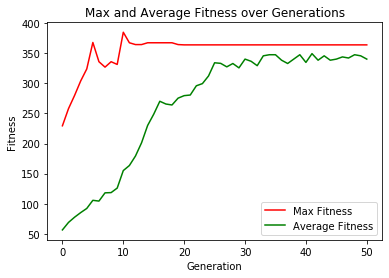

In [35]:
#导入模块
from deap import base,creator,tools,algorithms
import random
import numpy as np
import matplotlib.pyplot as plt

toolbox = base.Toolbox()

# 参数:
INDIVIDUAL_LENGTH = 6  # 
GRID_RANGE=20
POPULATION_SIZE = 200
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 50
random.seed(39)

# 3.create individual and population

#优化目标：单变量，求最大值 area
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

#创建Individual类，继承list
creator.create("Individual", list, fitness=creator.FitnessMax)

# 生成个体
toolbox.register("Indices", random.sample, range(1,GRID_RANGE-1),INDIVIDUAL_LENGTH)
#toolbox.register("Indices", random.randint, 0, 1)
toolbox.register("createIndividual", tools.initIterate, creator.Individual, toolbox.Indices)
print('随机 生成  个体 :',toolbox.createIndividual())

# 生成初始族群
toolbox.register("createPopulation", tools.initRepeat, list, toolbox.createIndividual)


# 4. define evaluation function
# 定义评价函数
def evalOneMax(individual):
    
    e=calc_area((individual[0],individual[1]),(individual[2],individual[3]),(individual[4],individual[5]))*min(individual)
    
    return e,

toolbox.register("evaluate",evalOneMax)

# 5. define operators
#配种选择,方式1,锦标赛方式
toolbox.register("select", tools.selTournament, tournsize=2)
#变异,单点交叉
toolbox.register("mate", tools.cxOnePoint)
#突变,位翻转突变
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/INDIVIDUAL_LENGTH)


# Genetic Algorithm flow:
def main():
    # create population
    population = toolbox.createPopulation(n=POPULATION_SIZE)
    # initialize statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    
    '''population
           toolbox
           cxpb –配对两个体的概率。
           mutpb –个体变异的概率。
           ngen –世代数。
           stats –一个Statistics就地更新的对象，可选。
           verbose –是否记录统计信息。'''
        
    # 遗传算法   Genetic Algorithm
    population, logbook = algorithms.eaSimple(
        population, 
        toolbox, 
        cxpb=P_CROSSOVER, 
        mutpb=P_MUTATION, 
        ngen=MAX_GENERATIONS,
        stats=stats, 
        verbose=True)


    # 输出最优解
    index = np.argmax([ind.fitness for ind in population])
    x = population[index] # 解码
    print('当前最优解：'+ str(x) + '\t对应的函数值为：' + str(population[index].fitness))
    
    # gather statistics
    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
    #print(population)
    # plot statistics:
    plt.plot(maxFitnessValues, color='red',label="Max Fitness")
    plt.plot(meanFitnessValues, color='green',label="Average Fitness")
    plt.legend()
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Max and Average Fitness over Generations')
    plt.show()

main()

## 试验想法，用遗传算法 来学习目标图片


/Users/shadow/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/shadow/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	max  	avg     	min  
0  	1000  	-6195	-7582.22	-9029
1  	901   	-5929	-7334   	-8683
2  	897   	-5879	-7086.75	-8526
3  	903   	-5443	-6842.14	-8123
4  	907   	-5529	-6624.32	-7821
5  	906   	-5182	-6428.95	-7579
6  	933   	-5194	-6237.01	-7342
7  	902   	-5002	-6059.96	-7000
8  	888   	-4825	-5885.19	-6806
9  	887   	-4507	-5719.42	-6880
10 	922   	-4538	-5536.67	-6667
11 	918   	-4210	-5367.44	-6321
12 	905   	-4013	-5203.9 	-6341
13 	894   	-3974	-5035.46	-5987
14 	932   	-3803	-4863.77	-5865
15 	914   	-3494	-4707.78	-5636
16 	928   	-3400	-4550   	-5610
17 	914   	-3400	-4391.25	-5370
18 	917   	-3241	-4242.96	-5184
19 	917   	-3298	-4095.87	-4930
20 	926   	-3207	-3947.1 	-4888
21 	891   	-3179	-3813.98	-4604
22 	912   	-3104	-3701.83	-4536
23 	895   	-3056	-3602.51	-4386
24 	911   	-2929	-3504.34	-4166
25 	896   	-2968	-3412.38	-4332
26 	916   	-2825	-3324.88	-3967
27 	896   	-2738	-3250.17	-3889
28 	886   	-2676	-3171.22	-3862
29 	908   	-2600	-3102.54	-3847
30 	926 

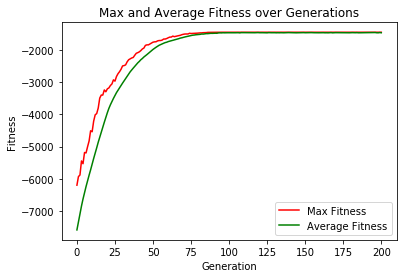

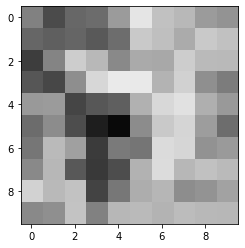

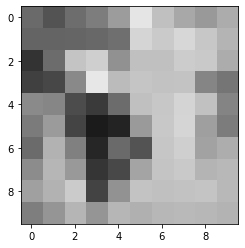

In [41]:
## 试验想法，用遗传算法 来生成布局
#导入模块
import cv2
from deap import base,creator,tools,algorithms
import random
import numpy as np
import matplotlib.pyplot as plt
image = cv2.imread('img/Maryam-Razavi_pitsitoppi590.jpg') 

image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image=cv2.resize(image, (10,10),interpolation = cv2.INTER_AREA)

# plt.imshow(image)
# plt.show()

image=image.reshape(100,)
#print(image.dtype)


toolbox = base.Toolbox()

# 参数:
INDIVIDUAL_LENGTH = 100  # 
GRID_RANGE=255
POPULATION_SIZE = 1000
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 200
random.seed(39)

# 3.create individual and population

#优化目标：单变量，求最大值 area
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
#创建Individual类，继承list
creator.create("Individual", list, fitness=creator.FitnessMax)

# 生成个体
toolbox.register("Indices", random.sample, range(0,GRID_RANGE),INDIVIDUAL_LENGTH)
toolbox.register("createIndividual", tools.initIterate, creator.Individual, toolbox.Indices)
# print(np.array(toolbox.createIndividual()).shape)
# print()

# 生成初始族群
toolbox.register("createPopulation", tools.initRepeat, list, toolbox.createIndividual)


# 4. define evaluation function
# 定义评价函数
def evalOneMax(individual):
    e=-(sum(abs(individual-image)))
    return e,

toolbox.register("evaluate",evalOneMax)

# 5. define operators
#配种选择,方式1,锦标赛方式
toolbox.register("select", tools.selTournament, tournsize=2)
#变异,单点交叉
toolbox.register("mate", tools.cxOnePoint)
#突变,位翻转突变
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/INDIVIDUAL_LENGTH)


# Genetic Algorithm flow:
def main():
    # create population
    population = toolbox.createPopulation(n=POPULATION_SIZE)
    # initialize statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    
    '''population
           toolbox
           cxpb –配对两个体的概率。
           mutpb –个体变异的概率。
           ngen –世代数。
           stats –一个Statistics就地更新的对象，可选。
           verbose –是否记录统计信息。'''
        
    # 遗传算法   Genetic Algorithm
    population, logbook = algorithms.eaSimple(
        population, 
        toolbox, 
        cxpb=P_CROSSOVER, 
        mutpb=P_MUTATION, 
        ngen=MAX_GENERATIONS,
        stats=stats, 
        verbose=True)


    # 输出最优解
    index = np.argmax([ind.fitness for ind in population])
    x = population[index] # 解码
    print('当前最优解：'+ str(x) + '\t对应的函数值为：' + str(population[index].fitness))
    
    # gather statistics
    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
    #print(population)
    # plot statistics:
    plt.plot(maxFitnessValues, color='red',label="Max Fitness")
    plt.plot(meanFitnessValues, color='green',label="Average Fitness")
    plt.legend()
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Max and Average Fitness over Generations')
    plt.show()
    x=np.array(x,np.uint8)
    plt.imshow(cv2.cvtColor(x.reshape(10,10),cv2.COLOR_GRAY2RGB))
    plt.show()
    
    plt.imshow(cv2.cvtColor(image.reshape(10,10),cv2.COLOR_GRAY2RGB))
    plt.show()

main()

In [51]:
np.array([0,2,3])-np.array([9,32,2])

array([ -9, -30,   1])

## 实验 随机分割网格


/Users/shadow/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/shadow/opt/anaconda3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


生成个体 [0, 1, 1, 0, 0, 0]
gen	nevals	max	avg	min
0  	200   	0  	0  	0  
1  	180   	0  	0  	0  
2  	180   	0  	0  	0  
3  	186   	0  	0  	0  
4  	185   	0  	0  	0  
5  	180   	0  	0  	0  
6  	185   	0  	0  	0  
7  	191   	0  	0  	0  
8  	184   	0  	0  	0  
9  	170   	0  	0  	0  
10 	177   	0  	0  	0  
11 	190   	0  	0  	0  
12 	184   	0  	0  	0  
13 	188   	0  	0  	0  
14 	193   	0  	0  	0  
15 	180   	0  	0  	0  
16 	185   	0  	0  	0  
17 	170   	0  	0  	0  
18 	181   	0  	0  	0  
19 	193   	0  	0  	0  
20 	185   	0  	0  	0  
21 	185   	0  	0  	0  
22 	189   	0  	0  	0  
23 	174   	0  	0  	0  
24 	175   	0  	0  	0  
25 	179   	0  	0  	0  
26 	186   	0  	0  	0  
27 	183   	0  	0  	0  
28 	174   	0  	0  	0  
29 	177   	0  	0  	0  
30 	188   	0  	0  	0  
31 	185   	0  	0  	0  
32 	182   	0  	0  	0  
33 	184   	0  	0  	0  
34 	172   	0  	0  	0  
35 	174   	0  	0  	0  
36 	176   	0  	0  	0  
37 	184   	0  	0  	0  
38 	184   	0  	0  	0  
39 	187   	0  	0  	0  
40 	192   	0  	0  	0  
41 	191   

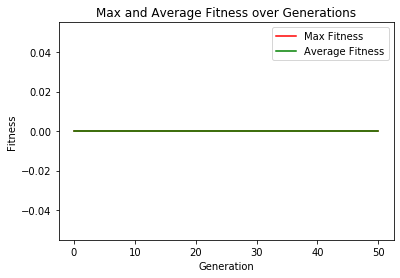

In [5]:
#导入模块
from deap import base,creator,tools,algorithms
import random
import numpy as np
import matplotlib.pyplot as plt

toolbox = base.Toolbox()

# 参数:
INDIVIDUAL_LENGTH = 6  # 
POPULATION_SIZE = 200
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 50
random.seed(39)

# 3.create individual and population
#优化目标：单变量，求最大值
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

#创建Individual类，继承list
creator.create("Individual", list, fitness=creator.FitnessMax)

# 生成个体
toolbox.register("Binary", random.randint, 0, 1)
toolbox.register("createIndividual", tools.initRepeat, creator.Individual, toolbox.Binary, INDIVIDUAL_LENGTH)

print('生成个体',toolbox.createIndividual())


# 生成初始族群
toolbox.register("createPopulation", tools.initRepeat, list, toolbox.createIndividual)


# 4. define evaluation function
# 定义评价函数

#通过三点直接求面积
def calc_area(p1, p2, p3):
    (x1, y1), (x2, y2), (x3, y3) = p1,p2,p3
    return 0.5 * abs(x2 * y3 + x1 * y2 + x3 * y1 - x3 * y2 - x2 * y1 - x1 * y3)

def evalOneMax(individual):
    
    e=calc_area((individual[0],individual[1]),(individual[2],individual[3]),(individual[4],individual[5]))*min(individual)
    
    return e,

toolbox.register("evaluate",evalOneMax)

# 5. define operators
#配种选择,方式1,锦标赛方式
toolbox.register("select", tools.selTournament, tournsize=2)
#变异,单点交叉
toolbox.register("mate", tools.cxOnePoint)
#突变,位翻转突变
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/INDIVIDUAL_LENGTH)


# Genetic Algorithm flow:
def main():
    # create population
    population = toolbox.createPopulation(n=POPULATION_SIZE)
    # initialize statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    
    '''population
           toolbox
           cxpb –配对两个体的概率。
           mutpb –个体变异的概率。
           ngen –世代数。
           stats –一个Statistics就地更新的对象，可选。
           verbose –是否记录统计信息。'''
        
    # 遗传算法   Genetic Algorithm
    population, logbook = algorithms.eaSimple(
        population, 
        toolbox, 
        cxpb=P_CROSSOVER, 
        mutpb=P_MUTATION, 
        ngen=MAX_GENERATIONS,
        stats=stats, 
        verbose=True)


    # 输出最优解
    index = np.argmax([ind.fitness for ind in population])
    x = population[index] # 解码
    print('当前最优解：'+ str(x) + '\t对应的函数值为：' + str(population[index].fitness))
    
    # gather statistics
    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
    #print(population)
    # plot statistics:
    plt.plot(maxFitnessValues, color='red',label="Max Fitness")
    plt.plot(meanFitnessValues, color='green',label="Average Fitness")
    plt.legend()
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Max and Average Fitness over Generations')
    plt.show()

main()

## 动态规划

## 找到和最大的子矩阵

In [82]:
# 找到和最大的子矩阵
# function to find maximum sum width x height sub-matrix

def findMaxSumSubMatrix(mat, width,height):

    # M x N 矩阵
    (M, N) = (len(mat), len(mat[0]))

    # pre-process the input matrix such that sum[i][j] stores
    # 总和 (0, 0) to (i, j)
    sum = [[0 for x in range(N)] for y in range(M)]
    
    sum[0][0] = mat[0][0]
     
    # 预处理第一行
    for j in range(1, N):
        sum[0][j] = mat[0][j] + sum[0][j - 1]
    
    # 预处理第一列
    for i in range(1, M):
        sum[i][0] = mat[i][0] + sum[i - 1][0]
    
    # 处理剩下的
    for i in range(1, M):
        for j in range(1, N):
            sum[i][j] = mat[i][j] + sum[i - 1][j] + sum[i][j - 1] - sum[i - 1][j - 1]

    max = float('-inf')
     
    # find maximum sum sub-matrix

    # 从 (width - 1, heigth - 1) 开始 and consider each
    # sub-matrix of size width x height
    for i in range(width - 1, M):
        for j in range(height - 1, N):

            # Note (i, j) is bottom right corner coordinates of
            # square sub-matrix of size k

            total = sum[i][j]
            if i - width >= 0:
                total = total - sum[i - width][j]

            if j - height >= 0:
                total = total - sum[i][j - height]

            if i - width >= 0 and j - height >= 0:
                total = total + sum[i - width][j -height]

            if total > max:
                max = total
                p = (i, j)

    # returns coordinates of bottom right corner of sub-matrix
    return p


# 3 x 3 matrix
mat = [
        [0,0,0,255 ],
        [0 ,0,0,255],
        [0,0,255,255 ],
        [0,255,255,255 ]
    ]

# sub-matrix size
width = 2
height=3

# p contains bottom right corner coordinates of sub-matrix
(x, y) = findMaxSumSubMatrix(mat, width,height)
print("左上角")
print(x-width+1,y-height+1)
print("右下角")
print(x,y)
print("子矩阵")
# print maximum sum sub-matrix
for i in range(width):
    for j in range(height):
        print(mat[i + x - width + 1][j + y - height + 1], end=' ')
    print()

左上角
2 1
右下角
3 3
子矩阵
0 255 255 
255 255 255 


# DEMO

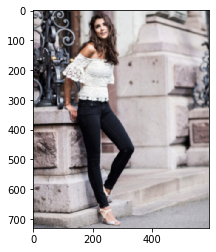

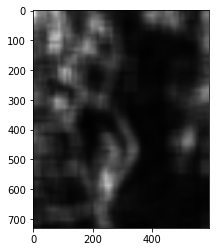

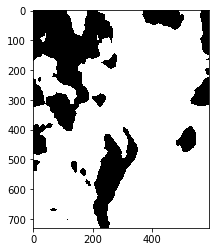

In [42]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('img/Maryam-Razavi_pitsitoppi590.jpg')

#像素3的高斯模糊，过滤掉小噪点
img = cv2.GaussianBlur(img,(9,9),0)  
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()
#StaticSaliencySpectralResidual_create
#
saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
(success, saliency_map) = saliency.computeSaliency(img)
saliency_map = (saliency_map * 255).astype("uint8")

#saliency_map=cv2.dilate(saliency_map,(27,27),iterations = 1)

plt.imshow(cv2.cvtColor(saliency_map,cv2.COLOR_BGR2RGB))
plt.show()

#二值化，按固定阈值分割
thresh_map = 255-cv2.threshold(saliency_map, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(cv2.cvtColor(thresh_map,cv2.COLOR_GRAY2RGB))
plt.show()

# _, labels = cv2.connectedComponents(thresh_map)
# print(labels)


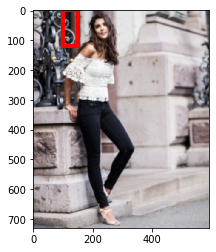

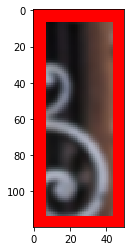

In [280]:
# 演示2 绘制矩形 与 截取图片 的差异
x=100
y=0 
w=50 
h=120
cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),12)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()


# 
# img[y:y+h,x:x+w]


#
plt.imshow(
    cv2.cvtColor(
        img[y:y+h,x:x+w],
        cv2.COLOR_BGR2RGB)
)
plt.show()


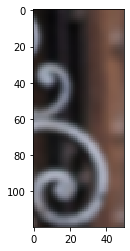

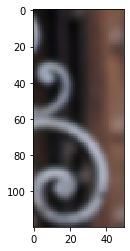

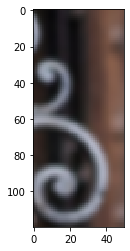

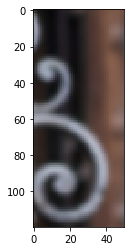

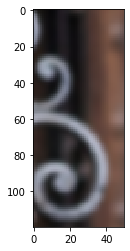

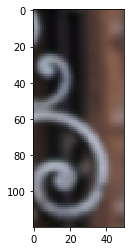

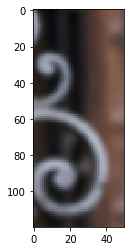

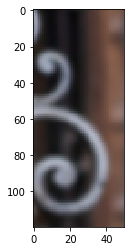

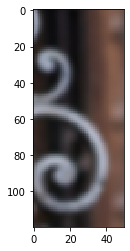

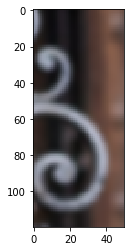

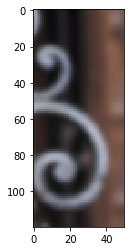

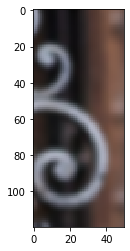

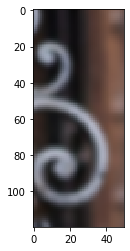

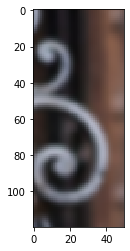

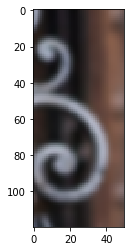

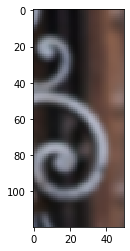

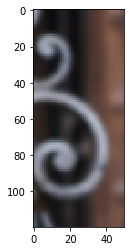

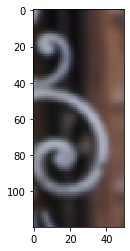

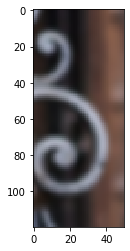

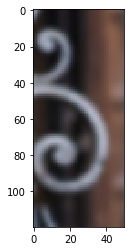

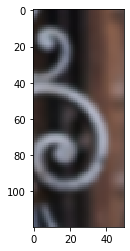

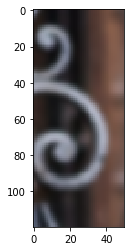

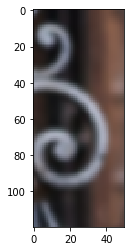

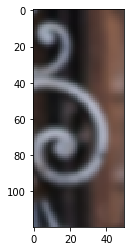

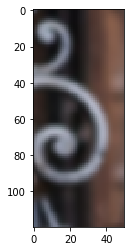

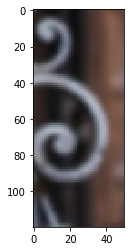

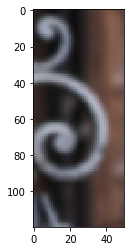

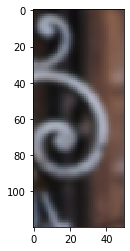

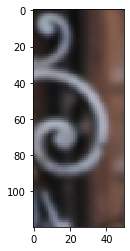

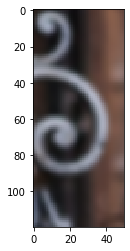

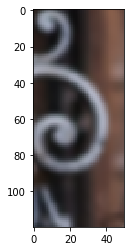

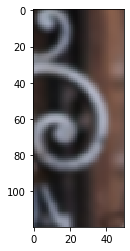

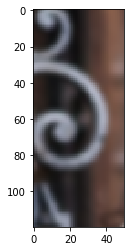

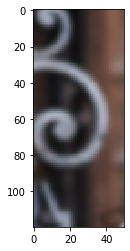

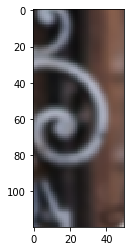

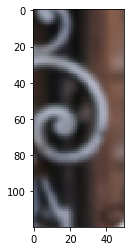

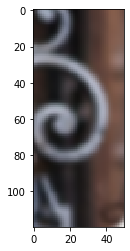

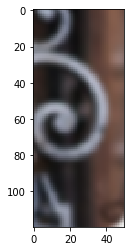

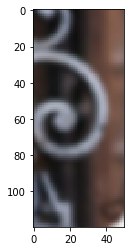

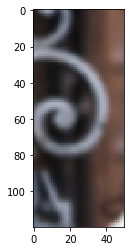

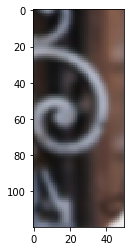

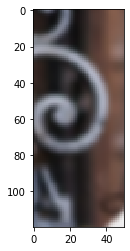

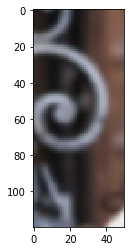

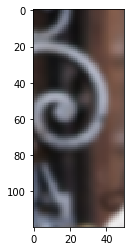

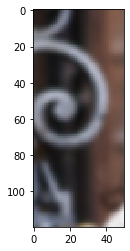

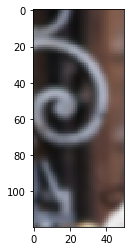

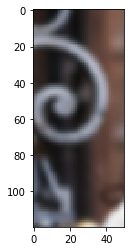

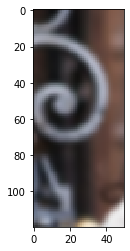

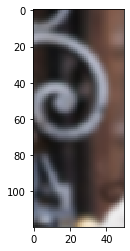

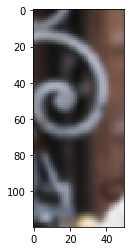

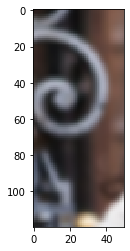

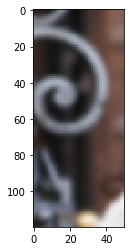

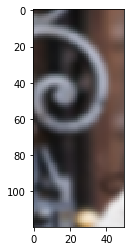

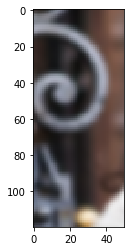

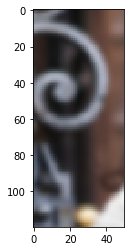

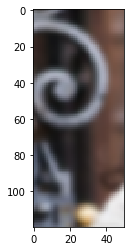

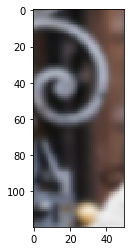

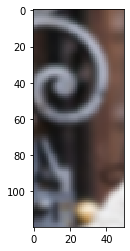

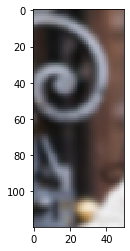

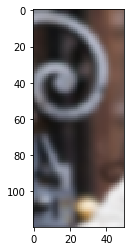

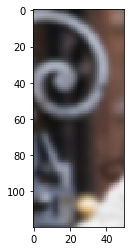

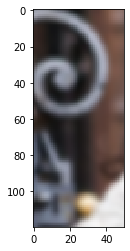

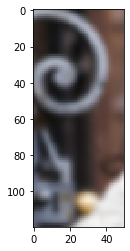

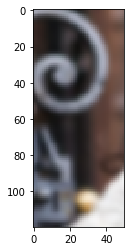

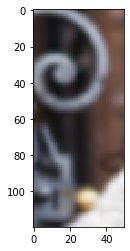

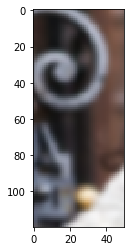

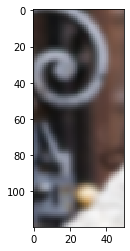

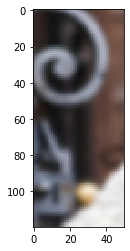

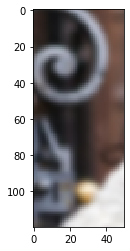

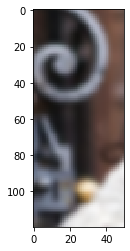

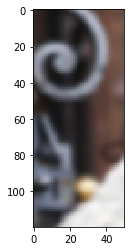

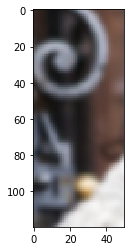

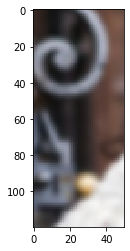

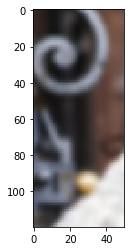

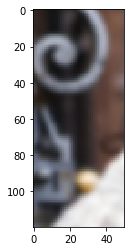

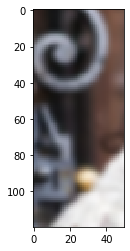

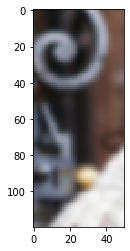

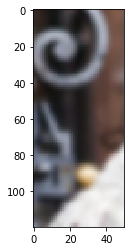

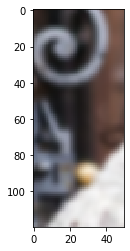

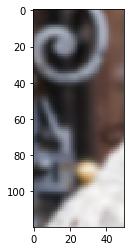

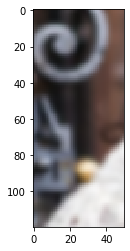

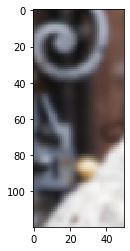

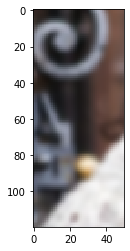

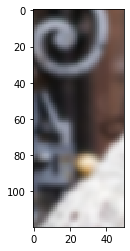

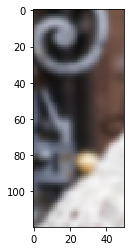

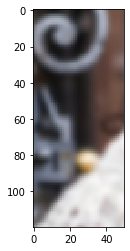

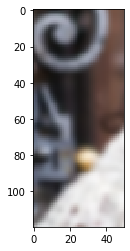

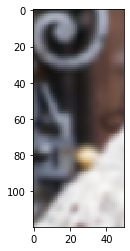

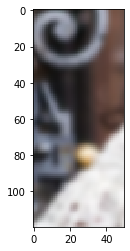

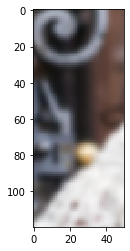

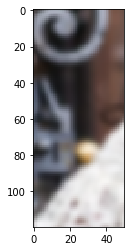

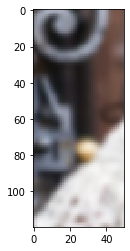

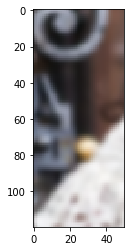

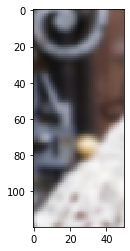

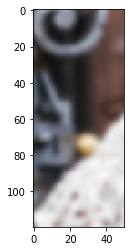

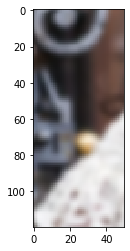

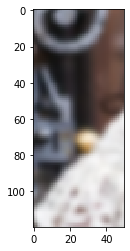

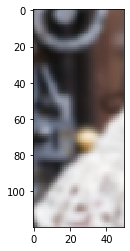

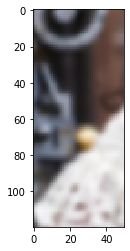

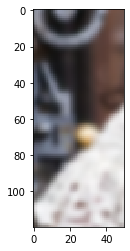

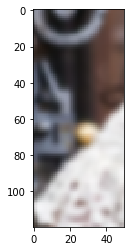

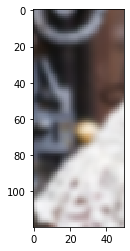

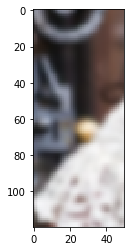

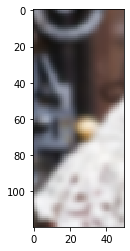

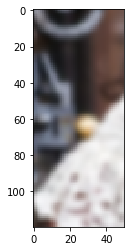

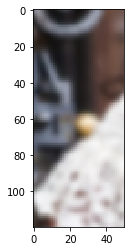

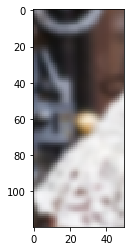

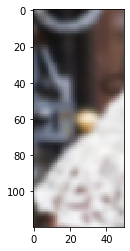

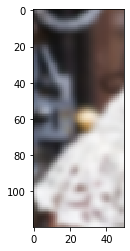

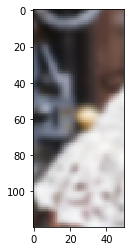

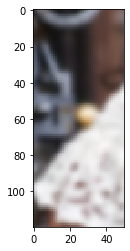

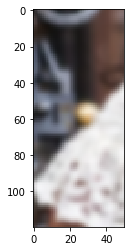

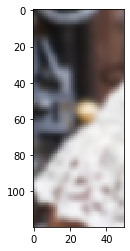

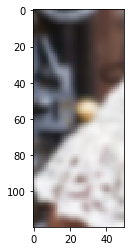

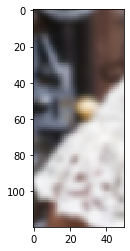

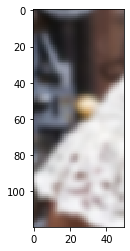

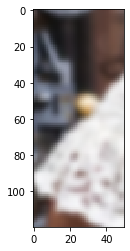

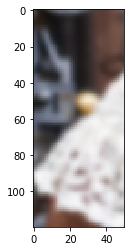

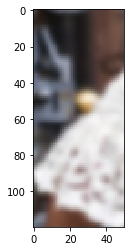

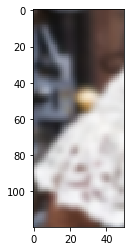

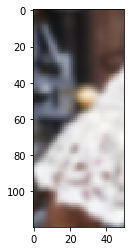

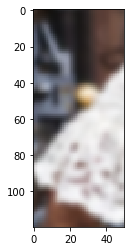

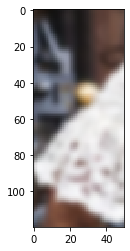

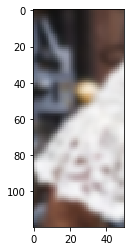

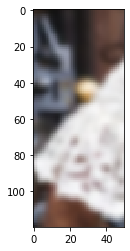

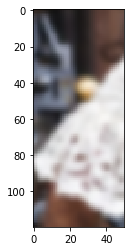

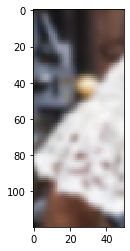

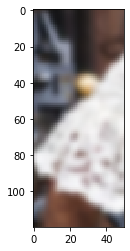

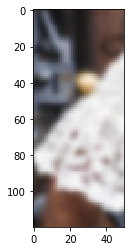

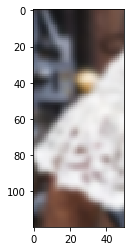

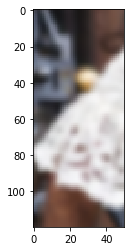

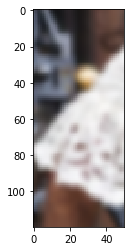

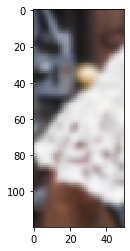

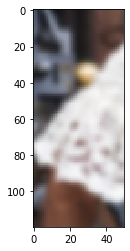

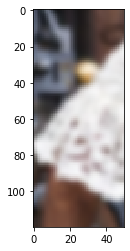

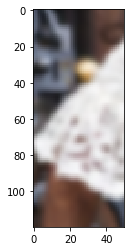

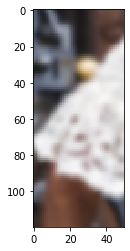

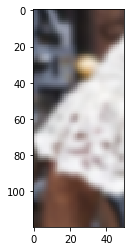

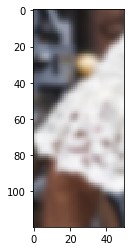

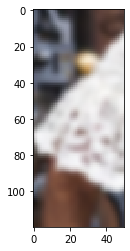

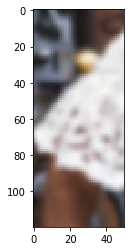

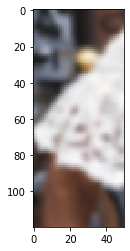

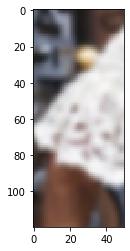

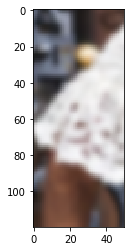

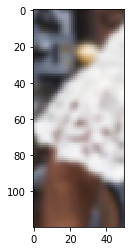

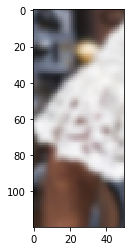

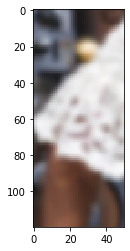

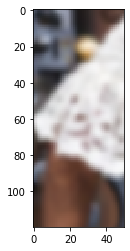

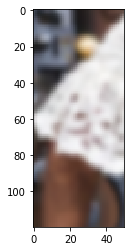

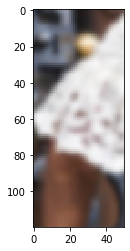

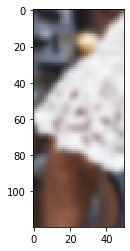

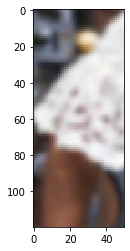

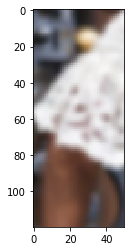

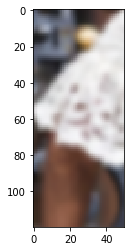

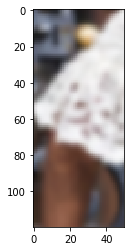

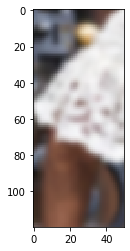

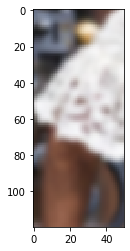

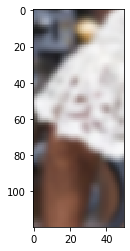

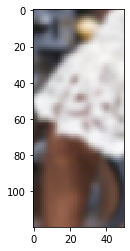

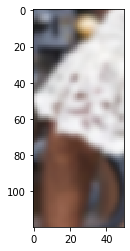

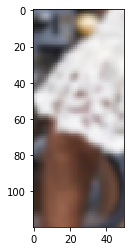

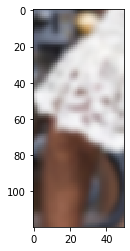

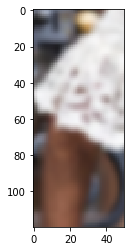

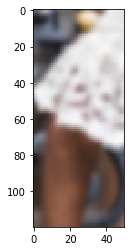

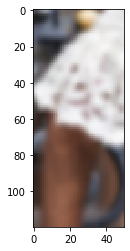

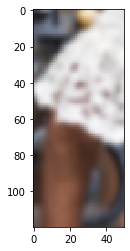

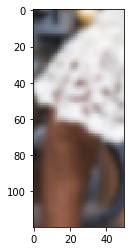

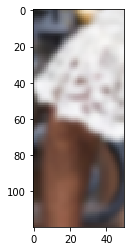

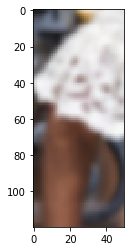

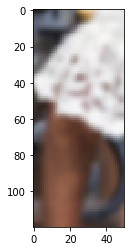

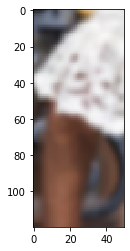

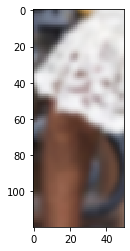

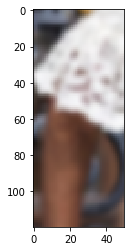

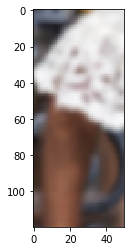

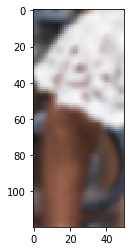

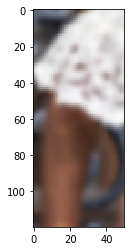

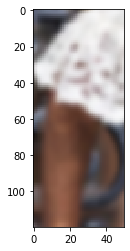

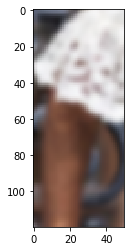

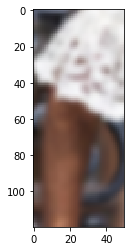

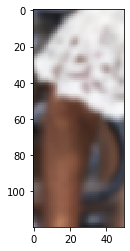

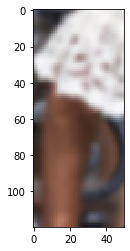

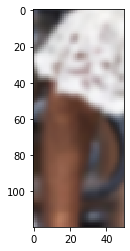

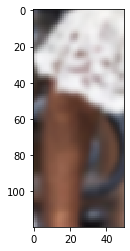

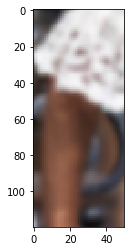

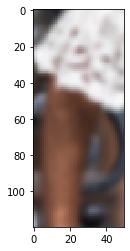

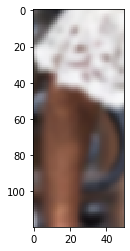

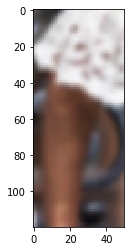

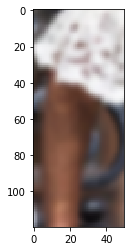

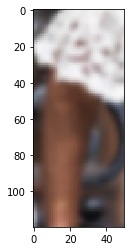

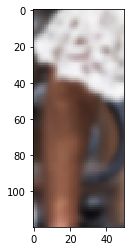

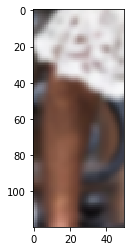

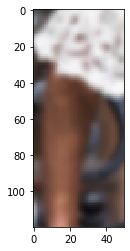

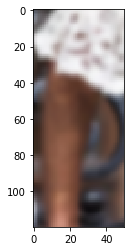

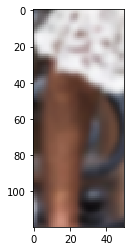

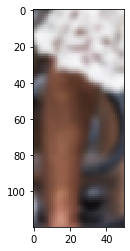

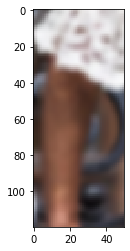

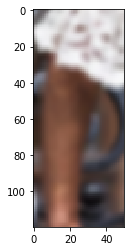

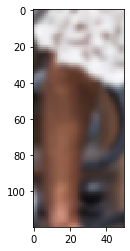

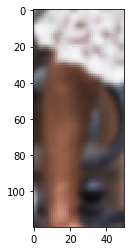

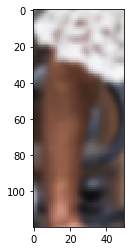

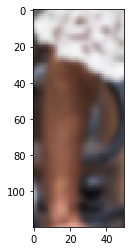

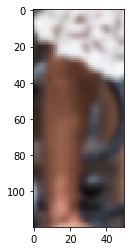

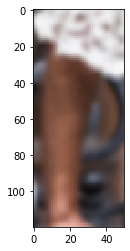

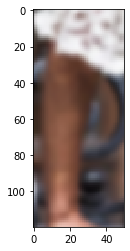

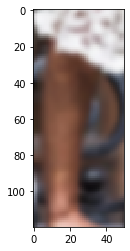

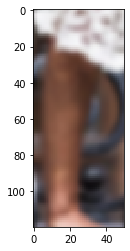

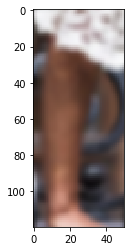

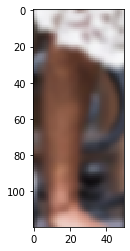

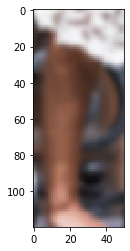

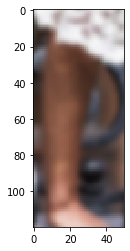

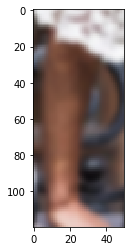

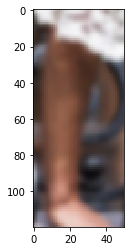

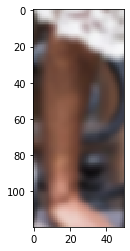

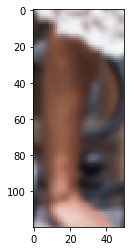

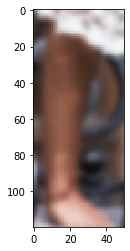

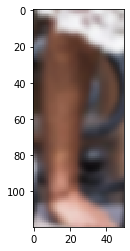

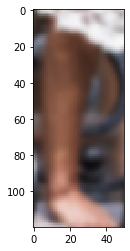

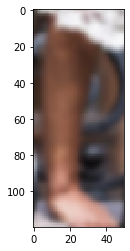

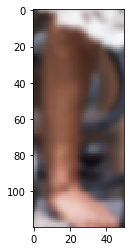

KeyboardInterrupt: 

In [44]:
# 演示3 固定尺寸矩阵 沿x轴移动
x=100
y=0 
w=50 
h=120

for i in range(img.shape[1]):
 # cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),12)
# plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
# plt.show()
    plt.imshow(
        cv2.cvtColor(
            img[y:y+h,x+i:x+i+w],
            cv2.COLOR_BGR2RGB)
    )
    plt.show()
    
# for j in range(img.shape[0]):
#  # cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),12)
# # plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
# # plt.show()
#     plt.imshow(
#         cv2.cvtColor(
#             img[y+j:y+j+h,x:x+w],
#             cv2.COLOR_BGR2RGB)
#     )
#     plt.show()

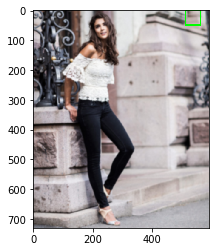

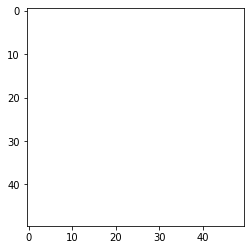

In [51]:
#演示4 按照二值图取背景区域上的固定矩阵(沿x轴)
w=50
h=50
max_area=0
max_i=0
img3=img.copy()

# plt.imshow(cv2.cvtColor(
#             thresh_map,
#             cv2.COLOR_BGR2RGB))
# plt.show()

for i in range(thresh_map.shape[1]):
    #print(i)
    area=np.sum(thresh_map[0:h,i:i+w])
    #print('面积大小',area)
    if area>=max_area:
        max_area=area
        max_i=i
#         plt.imshow(cv2.cvtColor(thresh_map[0:h,i:i+w],cv2.COLOR_GRAY2RGB))
#         plt.show()
#print(i)
cv2.rectangle(img3,(max_i,0),(max_i+w,h),(0,255,0),4)

plt.imshow(cv2.cvtColor(
            img3,
            cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(
            thresh_map[0:h,max_i:max_i+w],
            cv2.COLOR_BGR2RGB))
plt.show()

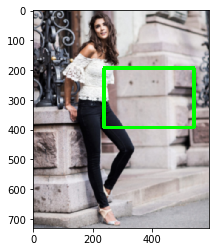

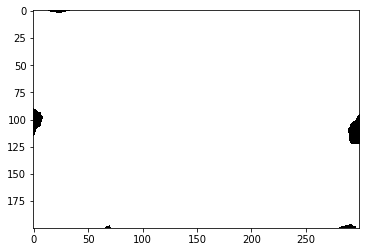

15.426119804382324


In [296]:
#演示5 按照二值图取背景区域上的固定矩阵
import time
t1=time.time()

w=300
h=200
max_area=0
max_i=0
max_j=0
img4=img.copy()
for i in range(thresh_map.shape[1]):
    #print(i)
    for j in range(thresh_map.shape[0]):
        area=np.sum(thresh_map[j:j+h,i:i+w])
        #print(area)
        if area>=max_area:
            max_area=area
            max_i=i
            max_j=j
    #         plt.imshow(cv2.cvtColor(thresh_map[0:h,i:i+w],cv2.COLOR_GRAY2RGB))
    #         plt.show()

cv2.rectangle(img4,(max_i,max_j),(max_i+w,max_j+h),(0,255,0),12)

plt.imshow(cv2.cvtColor(
            img4,
            cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(
            thresh_map[max_j:max_j+h,max_i:max_i+w],
            cv2.COLOR_BGR2RGB))
plt.show()
print('耗时：',time.time()-t1)

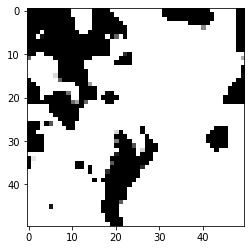

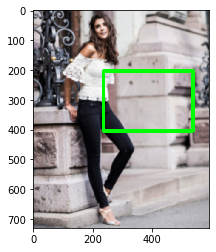

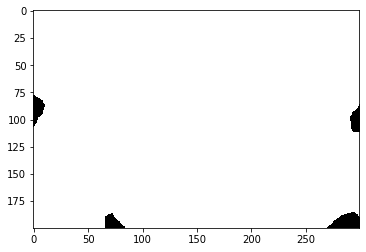

耗时： 0.44834375381469727


In [56]:
#演示6 缩减计算时间
import time
t1=time.time()

w=300
h=200
max_area=0
max_i=0
max_j=0
img4=img.copy()

#
H,W,N=img4.shape
T=50

#缩小
thresh_map2=cv2.resize(thresh_map, (T,T), interpolation=cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(
            thresh_map2,
            cv2.COLOR_BGR2RGB))
plt.show()

#缩小比例
scale_h=T/H
scale_w=T/W
#缩小后的宽高
h2=int(h*scale_h)
w2=int(w*scale_w)

for i in range(thresh_map2.shape[1]):
    #print(i)
    for j in range(thresh_map2.shape[0]):
        area=np.sum(thresh_map2[j:j+h2,i:i+w2])
        #print(area)
        if area>=max_area:
            max_area=area
            max_i=i
            max_j=j

#放大
max_i=int(max_i/scale_w)
max_j=int(max_j/scale_h)

cv2.rectangle(img4,(max_i,max_j),(max_i+w,max_j+h),(0,255,0),12)

plt.imshow(cv2.cvtColor(
            img4,
            cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(
            thresh_map[max_j:max_j+h,max_i:max_i+w],
            cv2.COLOR_BGR2RGB))
plt.show()
print('耗时：',time.time()-t1)

# 绘制汉字

In [57]:
from PIL import Image, ImageDraw, ImageFont

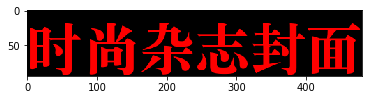

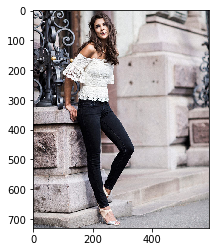

In [68]:
img = cv2.imread('img/Maryam-Razavi_pitsitoppi590.jpg')
 
# PIL图片上打印汉字
font = ImageFont.truetype("/System/Library/Fonts/Supplemental/Songti.ttc",80, encoding="utf-8") # 参数1：字体文件路径，参数2：字体大小
#print(font.getsize("时尚杂志封面"))
FW,FH=font.getsize("时尚杂志封面")

text_image = Image.fromarray(np.zeros((FH,FW,3), np.uint8))

draw = ImageDraw.Draw(text_image)
draw.text((0, 0), "时尚杂志封面", (255, 0, 0), font=font) # 参数1：打印坐标，参数2：文本，参数3：字体颜色，参数4：字体



# PIL图片转cv2 图片
text_image = cv2.cvtColor(np.array(text_image), cv2.COLOR_RGB2BGR)

plt.imshow(cv2.cvtColor(
            text_image,
            cv2.COLOR_BGR2RGB))
plt.show()



#img[0:FH,0:FW]=text_image

plt.imshow(cv2.cvtColor(
            img,
            cv2.COLOR_BGR2RGB))
plt.show()



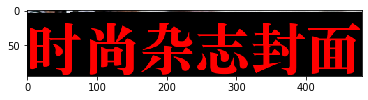

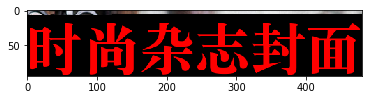

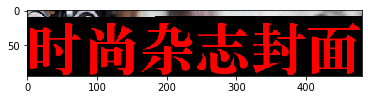

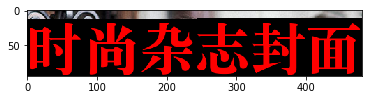

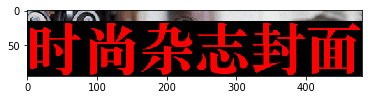

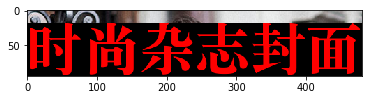

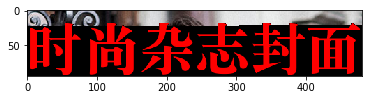

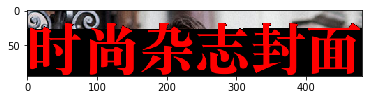

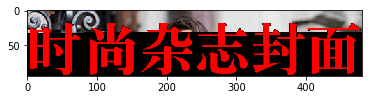

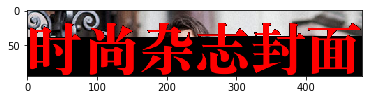

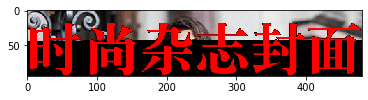

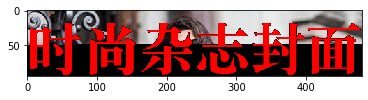

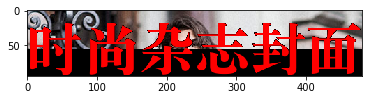

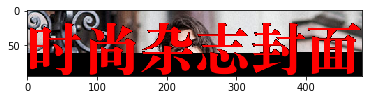

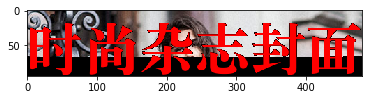

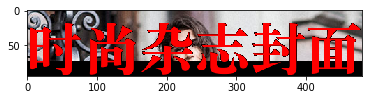

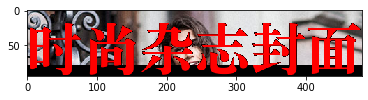

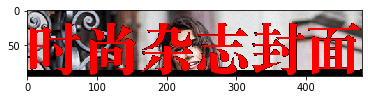

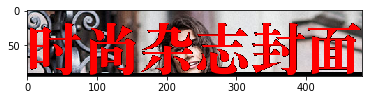

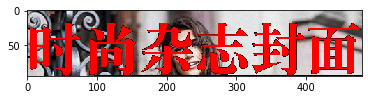

In [69]:
bg=img[0:FH,0:FW].copy()
m=0
for i in range(text_image.shape[0]):
    for j in range(text_image.shape[1]):
        if np.sum(text_image[i,j])==0:
            text_image[i,j]=bg[i,j]
            m+=1
            if m>1500:
                plt.imshow(cv2.cvtColor(
                text_image,
                cv2.COLOR_BGR2RGB))
                plt.show()
                m=0

In [70]:
img[0:FH,0:FW]=text_image

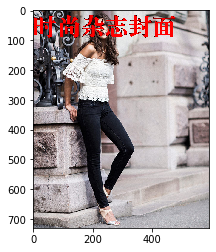

In [71]:
plt.imshow(cv2.cvtColor(
            img,
            cv2.COLOR_BGRA2RGB))
plt.show()